# Visualizing profiles of concentrations of elements quantified through ion chromatography

In [20]:
# For numerical calculations
import numpy as np
import pandas as pd
import scipy as sp
import math
import matplotlib.animation as animation
from scipy.integrate import odeint
from numpy import arange
from pylab import *
from scipy.integrate import odeint
import scipy.optimize 
from scipy.optimize import leastsq
from scipy.optimize import curve_fit
from math import exp
from collections import OrderedDict
from sklearn.linear_model import LinearRegression
pd.options.mode.chained_assignment = None
from scipy.signal import savgol_filter
import git

# Find home directory for repo
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

# Import plotting features
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("ticks")
sns.set_palette("colorblind", color_codes=True)
sns.set_context("talk")

# Magic command to plot inline
%matplotlib inline

#To graph in SVG (high def)
%config InlineBackend.figure_format="svg"

In [21]:
#Let's start by importing the file with the data
df_ic = pd.read_csv(f'{homedir}/data/raw/quantifications/SR2113_IC.csv')
#Fill nan with 0
df_ic['real_conc'] = df_ic['real_conc'].fillna(0)
df_ic = df_ic.sort_values('Real_depth_cm')
df_ic

,br correction factor,ID,meas_conc,br_corr,real_conc,Concentration_units,Ion,Depth_cm,Station,Core,Real_depth_cm,Unnamed: 11
232,NaN,CR3-2-55,NaN,NaN,49.880000,uM,Nitrate,NaN,CR03,GC04,0.00,BC
194,NaN,CR2-2-55,NaN,NaN,43.080000,uM,Nitrate,NaN,CR02,GC02,0.60,BC
195,NaN,CR2-2-58,NaN,NaN,39.140000,uM,Nitrate,NaN,CR02,GC02,1.85,BC
0,0.994940,2,966.688000,971.604553,10.304369,mM,Calcium,2.0,SCB01,MC01,2.00,NaN
439,0.965928,2,545.792150,565.044510,52.958380,mM,Magnesium,2.0,SCB01,MC01,2.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
648,0.769880,87,193.591800,251.457268,27.884739,mM,Sulfate,195.0,CR03,GC04,201.00,NaN
649,1.100241,82,278.587200,253.205624,27.859357,mM,Sulfate,200.0,CR03,GC04,206.00,NaN
82,1.100241,82,966.304562,98.127191,10.522719,mM,Calcium,200.0,CR03,GC04,206.00,NaN
523,0.984747,82,527.988790,536.166951,48.633554,mM,Magnesium,200.0,CR03,GC04,206.00,NaN


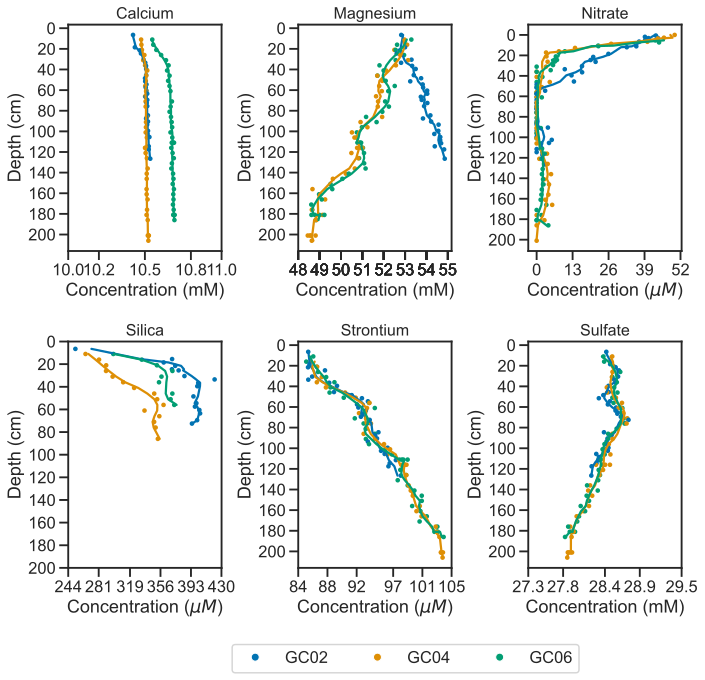

In [5]:
#Create profile plots with curve fit

#Exclude multicore

df_ic_gc = df_ic[(df_ic.Core != 'MC01')]

# define a fifth-degree polynomial objective function
#def objective(x, a, b, c):
	#return a * x + b * x**2 + c

# Group data by compound and core
grouped_by_ion = df_ic_gc.groupby('Ion')

# Initialize figure
fig, ax = plt.subplots(2,3, figsize=(11, 10))

#Flatten the 2D numpy array to be able to make subplots along multiple axes
ax = ax.flatten()

# Create dictionary with element concentrations
conc_dict = {'Calcium':'mM', 'Magnesium': 'mM', 'Strontium':'$\mu M$', 
         'Nitrate':'$\mu M$', 'Silica':'$\mu M$', 'Sulfate':'mM'}

for i, (group, data) in enumerate(grouped_by_ion):
    #Get the proper concentration for the element
    # Get Unique core labels
    color_labels = sort(df_ic_gc['Core'].unique())
    # Define colors
    colors = sns.color_palette("colorblind", len(color_labels))
    # Create dictionary that pairs core labels with colors
    color_map = dict(zip(color_labels, colors))
    # Map core labels to the colors
    color = data["Core"].map(color_map)

    ax[i].scatter(data["real_conc"], data["Real_depth_cm"], color=color, s=10)
    
    #Filter to get data for each core
    #MC01_data = data[(data.Core == 'MC01')]
    GC02_data = data[(data.Core == 'GC02')]
    GC04_data = data[(data.Core == 'GC04')]
    GC06_data = data[(data.Core == 'GC06')]
    
    #x_MC01 = MC01_data["real_conc"].values[0]
    #print(x_MC01)

    # curve fit
    #popt_MC01, _ = curve_fit(objective, MC01_data["real_conc"], MC01_data["Depth_cm"], maxfev=5000)
    #popt_GC02, _ = curve_fit(objective, GC02_data["real_conc"], GC02_data["Depth_cm"], maxfev=5000)
    #popt_GC04, _ = curve_fit(objective, GC04_data["real_conc"], GC04_data["Depth_cm"], maxfev=5000)
    #popt_GC06, _ = curve_fit(objective, GC06_data["real_conc"], GC06_data["Depth_cm"], maxfev=5000)

    # summarize the parameter values
    #a_MC01, b_MC01, c_MC01 = popt_MC01
    #a_GC02, b_GC02, c_GC02 = popt_GC02
    #a_GC04, b_GC04, c_GC04 = popt_GC04
    #a_GC06, b_GC06, c_GC06 = popt_GC06

    # define a sequence of inputs between the smallest and largest known inputs
    #x_line_MC01 = arange(min(MC01_data["real_conc"]), max(MC01_data["real_conc"]), 1)
   # x_line_GC02 = arange(min(GC02_data["real_conc"]), max(GC02_data["real_conc"]), 1)
    #x_line_GC04 = arange(min(GC04_data["real_conc"]), max(GC04_data["real_conc"]), 1)
    #x_line_GC06 = arange(min(GC06_data["real_conc"]), max(GC06_data["real_conc"]), 1)

    # calculate the output for the range
    #y_line_MC01 = objective(x_line_MC01, a_MC01, b_MC01, c_MC01)
    #y_line_GC02 = objective(x_line_GC02, a_GC02, b_GC02, c_GC02)
    #y_line_GC04 = objective(x_line_GC04, a_GC04, b_GC04, c_GC04)
    #y_line_GC06 = objective(x_line_GC06, a_GC06, b_GC06, c_GC06)
    #print (len (MC01_data["real_conc"]))
    
    #Create a Savitzky-Golay filter. It uses least squares to regress a small window of your data onto a polynomial, 
    #then uses the polynomial to estimate the point in the center of the window. Finally the window is shifted forward 
    #by one data point and the process repeats. This continues until every point has been optimally adjusted relative 
    #to its neighbors. It works great even with noisy samples from non-periodic and non-linear sources.
    #xhat_MC01 = savgol_filter(MC01_data["real_conc"], 9, 3) # window size 51, polynomial order 3
    xhat_GC02 = savgol_filter(GC02_data["real_conc"], 9, 3) # window size 51, polynomial order 3
    xhat_GC04 = savgol_filter(GC04_data["real_conc"], 9, 3) # window size 51, polynomial order 3
    xhat_GC06 = savgol_filter(GC06_data["real_conc"], 9, 3) # window size 51, polynomial order 3

    #Plot the Savitzky-Golay curve for each core on top of the scatter plots
    #ax[i].plot(x_line_MC01, y_line_MC01)
    #ax[i].plot(x_line_GC02, y_line_GC02)
    #ax[i].plot(x_line_GC04, y_line_GC04)
    #ax[i].plot(x_line_GC06, y_line_GC06)
    #ax[i].plot(xhat_MC01, MC01_data["Depth_cm"])
    ax[i].plot(xhat_GC02, GC02_data["Real_depth_cm"])
    ax[i].plot(xhat_GC04, GC04_data["Real_depth_cm"])
    ax[i].plot(xhat_GC06, GC06_data["Real_depth_cm"])
    
    
    #Get handles for legend
    handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8)
              for k, v in color_map.items()]

    # Set plot title
    ax[i].set_title(f"{group}", fontsize =16)#, bbox=dict(facecolor=colors[i], alpha=0.4))
    
    #Map element to its concentration units
    conc= conc_dict[group]
    # Set axis labels
    ax[i].set_xlabel('Concentration ({0:s})'.format(conc))
    ax[i].set_ylabel(r"Depth (cm)")
    
    #Invert y axis
    ax[i].invert_yaxis()
    
    #Set axis limits and tick marks
    ax[i].set_xticks(np.linspace(ax[i].get_xbound()[0], ax[i].get_xbound()[1], 6).round(0))
    ax[i].set_yticks(np.arange(0, 220, 20.0))
    ax[5].set_xticks(np.linspace((ax[5].get_xbound()[0])-0.5, (ax[5].get_xbound()[1])+0.5, 5).round(1))
    ax[1].set_xticks(np.linspace((ax[1].get_xbound()[0]), (ax[1].get_xbound()[1]), 54).round(0))
    ax[2].set_xticks(np.linspace(0, ax[2].get_xbound()[1], 5).round(0))
    ax[0].set_xticks(np.linspace(ax[0].get_xbound()[0]-0.02, ax[0].get_xbound()[1]+0.02, 5).round(1))
    
# Swap subplot positions
#pos5 = ax[3].get_position()
#ax[2].set_position(ax[5].get_position()
#ax[2].set_position(pos5)

# Set legend
ax[4].legend(handles=handles, bbox_to_anchor=(0.7, -0.5), ncol=4, loc = 'lower center')
# Set spacing between subplots
plt.subplots_adjust(hspace=0.4, wspace=0.5)

#Save figure
fig.savefig(f'{homedir}/figures/major_ion_profiles.pdf', bbox_inches='tight')

From the Si data, seems like GC02 had an overpenetration of about 3.5cm (from the 3 cm depth point for GC02, although at 12 cm the value it reaches is already too high in Si compared to the multicores). GC04 and GC06 both had an overpenetration of about 6 cm. 

In [ ]:
# Make plot just for sulfate
#Filter by sulfate
df_sulfate= df_ic_gc[(df_ic_gc.Ion == 'Sulfate')]
# Group data by core
sulfate_grouped = df_sulfate.groupby('Core')
#Make plot
fig, ax = plt.subplots(figsize=(2.7,4))
for name, group in sulfate_grouped:
    ax.scatter(group.real_conc, group.Real_depth_cm, s=12, label=name)
    #ax.plot(group.Sample_conc_uM, group.Depth_cm)
    
    xhat = savgol_filter(group.real_conc, 9, 4, mode='nearest') # window size 51, polynomial order 3
    
    #Plot the Savitzky-Golay curve for each core on top of the scatter plots
    ax.plot(xhat, group.Real_depth_cm)
    
    # Set plot title
    ax.set_title('Sulfate', fontsize =16)

    #Invert y axis
    ax.invert_yaxis()
    ax.set_xlabel('Concentration (mM)')
    ax.set_ylabel('Depth (cm)')
    ax.set_yticks(np.arange(0, 220, 20.0))
    ax.set_xticks(np.linspace(27, 29, 6).round(0)) 
    #ax.set_xticks(np.linspace((ax.get_xbound()[0]), (ax.get_xbound()[1]), 5).round(1))
#ax.legend(bbox_to_anchor=(0.5, -0.25), ncol=4, loc = 'lower center')

#Save figure
fig.savefig(f'{homedir}/figures/sulfate_profile_talk.pdf', bbox_inches='tight')

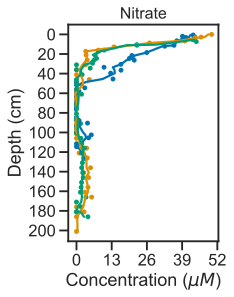

In [5]:
# Make plot just for nitrate
#Filter by nitrate
df_nitrate= df_ic_gc[(df_ic_gc.Ion == 'Nitrate')]
# Group data by core
nitrate_grouped = df_nitrate.groupby('Core')
#Make plot
fig, ax = plt.subplots(figsize=(2.7,4))
for name, group in nitrate_grouped:
    ax.scatter(group.real_conc, group.Real_depth_cm, s=12, label=name)
    #ax.plot(group.Sample_conc_uM, group.Depth_cm)
    
    xhat = savgol_filter(group.real_conc, 9, 4, mode='nearest') # window size 51, polynomial order 3
    
    #Plot the Savitzky-Golay curve for each core on top of the scatter plots
    ax.plot(xhat, group.Real_depth_cm)
    
    # Set plot title
    ax.set_title('Nitrate', fontsize =16)

    #Invert y axis
    ax.invert_yaxis()
    ax.set_xlabel('Concentration ($\mu M$)')
    ax.set_ylabel('Depth (cm)')
    ax.set_yticks(np.arange(0, 220, 20.0))
    ax.set_xticks(np.linspace(0, 50, 6).round(0)) 
    ax.set_xticks(np.linspace(0, (ax.get_xbound()[1]), 5).round(0))
#ax.legend(bbox_to_anchor=(0.5, -0.25), ncol=4, loc = 'lower center')

#Save figure
fig.savefig(f'{homedir}/figures/nitrate_profile_poster.pdf', bbox_inches='tight')

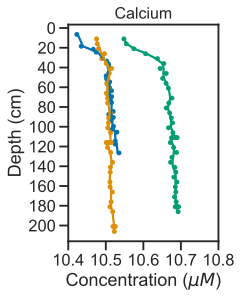

In [16]:
# Make plot just for calcium
#Filter by calcium
df_calcium= df_ic_gc[(df_ic_gc.Ion == 'Calcium')]
# Group data by core
calcium_grouped = df_calcium.groupby('Core')
#Make plot
fig, ax = plt.subplots(figsize=(2.7,4))
for name, group in calcium_grouped:
    ax.scatter(group.real_conc, group.Real_depth_cm, s=12, label=name)
    #ax.plot(group.Sample_conc_uM, group.Depth_cm)
    
    xhat = savgol_filter(group.real_conc, 9, 4, mode='nearest') # window size 51, polynomial order 3
    
    #Plot the Savitzky-Golay curve for each core on top of the scatter plots
    ax.plot(xhat, group.Real_depth_cm)
    
    # Set plot title
    ax.set_title('Calcium', fontsize =16)

    #Invert y axis
    ax.invert_yaxis()
    ax.set_xlabel('Concentration ($\mu M$)')
    ax.set_ylabel('Depth (cm)')
    ax.set_yticks(np.arange(0, 220, 20.0))
    #ax.set_xticks(np.linspace(0, 50, 6).round(0)) 
    ax.set_xticks(np.linspace(10.4,10.8, 5))
#ax.legend(bbox_to_anchor=(0.5, -0.25), ncol=4, loc = 'lower center')

#Save figure
fig.savefig(f'{homedir}/figures/calcium_profile_poster.pdf', bbox_inches='tight')

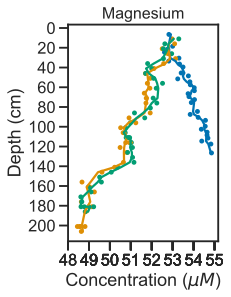

In [16]:
# Make plot just for magnesium
#Filter by magnesium
df_mg= df_ic_gc[(df_ic_gc.Ion == 'Magnesium')]
# Group data by core
mg_grouped = df_mg.groupby('Core')
#Make plot
fig, ax = plt.subplots(figsize=(2.7,4))
for name, group in mg_grouped:
    ax.scatter(group.real_conc, group.Real_depth_cm, s=12, label=name)
    #ax.plot(group.Sample_conc_uM, group.Depth_cm)
    
    xhat = savgol_filter(group.real_conc, 9, 4, mode='nearest') # window size 51, polynomial order 3
    
    #Plot the Savitzky-Golay curve for each core on top of the scatter plots
    ax.plot(xhat, group.Real_depth_cm)
    
    # Set plot title
    ax.set_title('Magnesium', fontsize =16)

    #Invert y axis
    ax.invert_yaxis()
    ax.set_xlabel('Concentration ($\mu M$)')
    ax.set_ylabel('Depth (cm)')
    ax.set_yticks(np.arange(0, 220, 20.0))
    ax.set_xticks(np.linspace((ax.get_xbound()[0]), (ax.get_xbound()[1]), 54).round(0))

#ax.legend(bbox_to_anchor=(0.5, -0.25), ncol=4, loc = 'lower center')

#Save figure
fig.savefig(f'{homedir}/figures/magnesium_profile_poster.pdf', bbox_inches='tight')

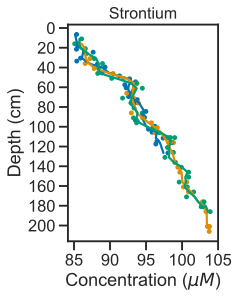

In [18]:
# Make plot just for strontium
#Filter by magnesium
df_strontium= df_ic_gc[(df_ic_gc.Ion == 'Strontium')]
# Group data by core
strontium_grouped = df_strontium.groupby('Core')
#Make plot
fig, ax = plt.subplots(figsize=(2.7,4))
for name, group in strontium_grouped:
    ax.scatter(group.real_conc, group.Real_depth_cm, s=12, label=name)
    #ax.plot(group.Sample_conc_uM, group.Depth_cm)
    
    xhat = savgol_filter(group.real_conc, 9, 4, mode='nearest') # window size 51, polynomial order 3
    
    #Plot the Savitzky-Golay curve for each core on top of the scatter plots
    ax.plot(xhat, group.Real_depth_cm)
    
    # Set plot title
    ax.set_title('Strontium', fontsize =16)

    #Invert y axis
    ax.invert_yaxis()
    ax.set_xlabel('Concentration ($\mu M$)')
    ax.set_ylabel('Depth (cm)')
    ax.set_yticks(np.arange(0, 220, 20.0))
    #ax.set_xticks(np.linspace((ax.get_xbound()[0]), (ax.get_xbound()[1]), 6).round(0))
    #ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))
    ax.set_xticks(np.linspace(85,105, 5))

#ax.legend(bbox_to_anchor=(0.5, -0.25), ncol=4, loc = 'lower center')

#Save figure
fig.savefig(f'{homedir}/figures/strontium_profile_poster.pdf', bbox_inches='tight')

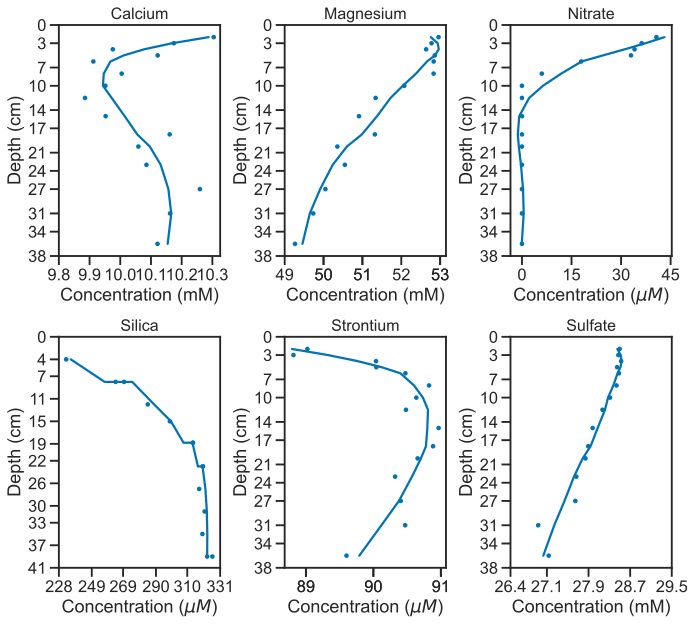

In [29]:
#Create profile plots with curve fit

#Multicore only

df_ic_mc = df_ic[(df_ic.Core == 'MC01')]

# Group data by compound and core
grouped_by_ion = df_ic_mc.groupby('Ion')

# Initialize figure
fig, ax = plt.subplots(2,3, figsize=(11, 10))

#Flatten the 2D numpy array to be able to make subplots along multiple axes
ax = ax.flatten()

# Create dictionary with element concentrations
conc_dict = {'Calcium':'mM', 'Magnesium': 'mM', 'Strontium':'$\mu M$', 
         'Nitrate':'$\mu M$', 'Silica':'$\mu M$', 'Sulfate':'mM'}

for i, (group, data) in enumerate(grouped_by_ion):

    ax[i].scatter(data["real_conc"], data["Depth_cm"], s=10)
    
    #Filter to get data for multicore
    MC01_data = data[(data.Core == 'MC01')]
    
    #Create a Savitzky-Golay filter. It uses least squares to regress a small window of your data onto a polynomial, 
    #then uses the polynomial to estimate the point in the center of the window. Finally the window is shifted forward 
    #by one data point and the process repeats. This continues until every point has been optimally adjusted relative 
    #to its neighbors. It works great even with noisy samples from non-periodic and non-linear sources.
    xhat_MC01 = savgol_filter(MC01_data["real_conc"], 13, 3) # window size 51, polynomial order 3
    
    #Plot the Savitzky-Golay curve for each core on top of the scatter plots
    ax[i].plot(xhat_MC01, MC01_data["Depth_cm"])
    
    #Get handles for legend
    handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8)
              for k, v in color_map.items()]

    # Set plot title
    ax[i].set_title(f"{group}", fontsize =16)#, bbox=dict(facecolor=colors[i], alpha=0.4))
    
    #Map element to its concentration units
    conc= conc_dict[group]
    # Set axis labels
    ax[i].set_xlabel('Concentration ({0:s})'.format(conc))
    ax[i].set_ylabel(r"Depth (cm)")
    
    #Invert y axis
    ax[i].invert_yaxis()
    
    #Set axis limits and tick marks
    ax[i].set_xticks(np.linspace(ax[i].get_xbound()[0], ax[i].get_xbound()[1], 6).round(0))
    ax[i].set_yticks(np.linspace(0, ax[i].get_ybound()[1], 12).round(0))
    ax[5].set_xticks(np.linspace((ax[5].get_xbound()[0])-0.5, (ax[5].get_xbound()[1])+0.5, 5).round(1))
    ax[1].set_xticks(np.linspace((ax[1].get_xbound()[0]), (ax[1].get_xbound()[1]), 8).round(0))
    ax[0].set_xticks(np.linspace(ax[0].get_xbound()[0]-0.02, ax[0].get_xbound()[1]+0.02, 6).round(1))
    ax[2].set_xticks(np.linspace(0, ax[2].get_xbound()[1], 4).round(0))
    
# Swap subplot positions
#pos5 = ax[3].get_position()
#ax[2].set_position(ax[5].get_position())
#ax[2].set_position(pos5)
# Set legend
#ax[4].legend(handles=handles, bbox_to_anchor=(0.5, -0.25), ncol=4, loc = 'lower center')
# Set spacing between subplots
plt.subplots_adjust(hspace=0.35, wspace=0.4)

#Save figure
fig.savefig(f'{homedir}/figures/major_ion_profiles_mc.pdf', bbox_inches='tight')


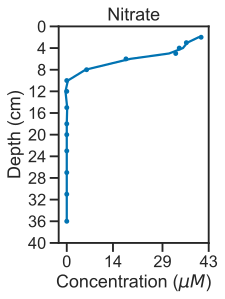

In [18]:
# Plot nitrate only
#Filter the multicore data for nitrate
df_ic_mc_nitrate = df_ic_mc[(df_ic_mc.Ion == 'Nitrate')]
#Initialize figure
fig, ax = plt.subplots(figsize=(2.7,4))
# Plot data
ax.scatter(df_ic_mc_nitrate.real_conc, df_ic_mc_nitrate.Depth_cm, s=12)
#Create a Savitzky-Golay filter
xhat = savgol_filter(df_ic_mc_nitrate.real_conc, 7, 5, mode='nearest') # window size 51, polynomial order 3
    
#Plot the Savitzky-Golay curve for each core on top of the scatter plots
ax.plot(xhat, df_ic_mc_nitrate.Depth_cm)
ax.set_title('Nitrate')
ax.set_xlabel('Concentration ($\mu M$)')
ax.set_ylabel('Depth (cm)')
   
ax.set_yticks(np.linspace(40, 0, 11).round(0))
ax.set_xticks(np.linspace(0, ax.get_xbound()[1], 4).round(0))
#Make plot start at depth 0 and end at 37
ax.set_ylim(bottom=0)
ax.set_ylim(top=40)
#ax.set_xlim(0)
#Invert y axis
ax.invert_yaxis()

#Save figure
fig.savefig(f'{homedir}/figures/mc_nitrate.pdf', bbox_inches='tight')

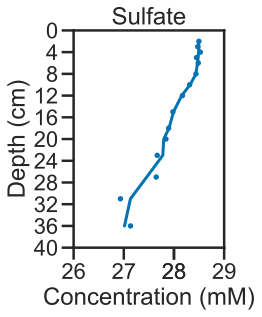

In [11]:
# Plot sulfate only
#Filter the multicore data for sulfate
df_ic_mc_sulfate = df_ic_mc[(df_ic_mc.Ion == 'Sulfate')]
#Initialize figure
fig, ax = plt.subplots(figsize=(2.7,4))
# Plot data
ax.scatter(df_ic_mc_sulfate.real_conc, df_ic_mc_sulfate.Depth_cm, s=12)
#Create a Savitzky-Golay filter
xhat = savgol_filter(df_ic_mc_sulfate.real_conc, 7, 5, mode='nearest') # window size 51, polynomial order 3
    
#Plot the Savitzky-Golay curve for each core on top of the scatter plots
ax.plot(xhat, df_ic_mc_sulfate.Depth_cm)
ax.set_title('Sulfate')
ax.set_xlabel('Concentration (mM)')
ax.set_ylabel('Depth (cm)')
   
ax.set_yticks(np.linspace(40, 0, 11).round(0))
ax.set_xticks(np.linspace((ax.get_xbound()[0])-0.5, (ax.get_xbound()[1])+0.5, 5).round(0))

#Make plot start at depth 0 and end at 37
ax.set_ylim(bottom=0)
ax.set_ylim(top=40)
#ax.set_xlim(0)
#Invert y axis
ax.invert_yaxis()

#Save figure
fig.savefig(f'{homedir}/figures/mc_sulfate_poster.pdf', bbox_inches='tight')

In [305]:
#Determining the precision
#Let's start by importing the file with the data
df_prec = pd.read_csv(f'{homedir}/data/raw/quantifications/IC_precision.csv')
df_prec

,runno,ID,Ret.Time,Amount,Rel.Area,Area,Height,Date,Core,Ion
0,5,SW3,16.810,26.6853,1.04,1.3966,7.28,20220124,MC01,Sulfate
1,10,SW3,16.817,26.8901,1.05,1.4077,7.36,20220124,MC01,Sulfate
2,11,SW3,16.803,26.7572,1.05,1.4005,7.31,20220124,MC01,Sulfate
3,12,SW3,16.817,26.8499,1.04,1.3892,7.32,20220124,MC01,Sulfate
4,36,SW3,16.820,26.8706,1.04,1.3904,7.34,20220124,MC01,Sulfate
...,...,...,...,...,...,...,...,...,...,...
104,10,SW3,12.763,4.9267,0.08,0.1091,0.56,20220309,GC04,Nitrate
105,11,SW3,12.760,4.7986,0.09,0.1062,0.54,20220309,GC06,Nitrate
106,36,SW3,12.760,4.7949,0.09,0.1061,0.54,20220309,GC06,Nitrate
107,60,SW3,12.760,4.7753,0.09,0.1057,0.54,20220309,GC06,Nitrate


In [312]:
#Group standards by identifier and amount
grouped_standards = df_prec.groupby(['Ion', 'Date'])

# Determine the mean of each standard  and rename the series
mean_stds = grouped_standards['Amount'].mean()
mean_stds = mean_stds.rename("Conc_mean")

# Determine the standard deviation of each standard  and rename the series
std_dev_stds = grouped_standards['Amount'].std()
std_dev_stds = std_dev_stds.rename("Conc_stdev")

#Pass series to individual dataframes
df_mean_stds=mean_stds.to_frame()
df_std_dev_stds=std_dev_stds.to_frame()

#merge the mean and standard deviation dataframes
df_anrep = pd.merge(df_mean_stds, df_std_dev_stds,  how='outer', on=['Ion', 'Date'])

#Reset index of the dataframe
df_anrep = df_anrep.reset_index()

#Add column of true value of the standards
df_anrep.loc[df_anrep['Ion'] \
                  == 'Sulfate', 'True_conc'] = 27.99
df_anrep.loc[df_anrep['Ion'] \
                  == 'Nitrate', 'True_conc'] = 5.172
df_anrep.loc[df_anrep['Ion'] \
                  == 'Calcium', 'True_conc'] = 0.9147
df_anrep.loc[df_anrep['Ion'] \
                  == 'Strontium', 'True_conc'] = 2
df_anrep.loc[df_anrep['Ion'] \
                  == 'Magnesium', 'True_conc'] = 80.0216

#Determine the accuracy by subtracting the true value from the average value of each standard
df_anrep ['% Error rate'] = (abs(df_anrep ['True_conc'] - df_anrep ['Conc_mean'])/df_anrep ['True_conc'])*100
df_anrep ['% RSD'] = df_anrep ['Conc_stdev']*100/ df_anrep ['Conc_mean'] 
df_anrep

,Ion,Date,Conc_mean,Conc_stdev,True_conc,% Error rate,% RSD
0,Calcium,20220124,0.993355,0.014977,0.9147,8.598945,1.507680
1,Calcium,20220209,0.957511,0.005347,0.9147,4.680284,0.558401
2,Calcium,20220309,0.972189,0.014174,0.9147,6.285030,1.457979
3,Magnesium,20220124,78.648627,0.201847,80.0216,1.715753,0.256644
4,Magnesium,20220209,79.522511,0.361683,80.0216,0.623693,0.454819
5,Magnesium,20220309,81.040767,0.512709,80.0216,1.273614,0.632656
6,Nitrate,20220209,4.661922,0.060288,5.1720,9.862293,1.293194
7,Nitrate,20220309,4.814100,0.056361,5.1720,6.919954,1.170741
8,Strontium,20220209,2.146306,0.026567,2.0000,7.315313,1.237811
9,Strontium,20220309,2.156294,0.021365,2.0000,7.814687,0.990803


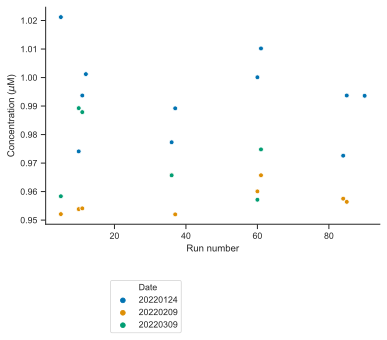

In [270]:
#Plot lines for a single ion
df_calc_prec = df_prec[(df_prec.Ion=='Calcium')]
#fig = plt.figure(figsize = (7,7), facecolor='white')
#ax = fig.add_subplot(111)
p = sns.scatterplot(x='runno', y='Amount', data=df_calc_prec, hue='Date', palette='colorblind')
sns.despine()

plt.ylabel('Concentration ($\mu$M)')
plt.xlabel('Run number')
plt.legend(bbox_to_anchor=(0.3, -0.5), loc='lower center', borderaxespad=0)
#Save figure
plt.savefig(f'{homedir}/figures/ic_precision_Ca.pdf', bbox_inches='tight')

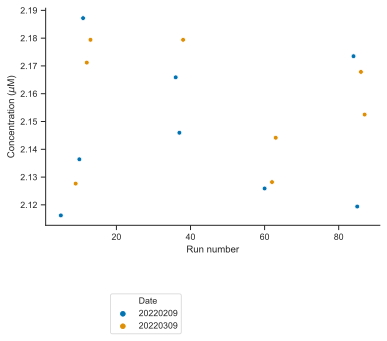

In [282]:
#Plot lines for a single ion
df_sr_prec = df_prec[(df_prec.Ion=='Strontium')]
#fig = plt.figure(figsize = (7,7), facecolor='white')
#ax = fig.add_subplot(111)
p = sns.scatterplot(x='runno', y='Amount', data=df_sr_prec, hue='Date', palette='colorblind')
sns.despine()

plt.ylabel('Concentration ($\mu$M)')
plt.xlabel('Run number')
plt.legend(bbox_to_anchor=(0.3, -0.5), loc='lower center', borderaxespad=0)
#Save figure
plt.savefig(f'{homedir}/figures/ic_precision_Sr.pdf', bbox_inches='tight')

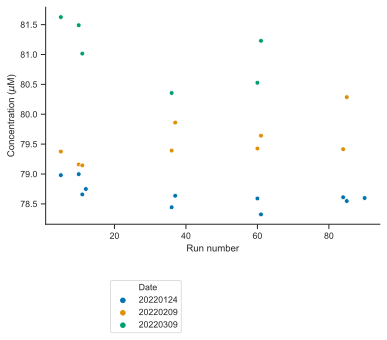

In [272]:
#Plot lines for a single ion
df_mag_prec = df_prec[(df_prec.Ion=='Magnesium')]
#fig = plt.figure(figsize = (7,7), facecolor='white')
#ax = fig.add_subplot(111)
p = sns.scatterplot(x='runno', y='Amount', data=df_mag_prec, hue='Date', palette='colorblind')
sns.despine()

plt.ylabel('Concentration ($\mu$M)')
plt.xlabel('Run number')
plt.legend(bbox_to_anchor=(0.3, -0.5), loc='lower center', borderaxespad=0)
#Save figure
plt.savefig(f'{homedir}/figures/ic_precision_Mg.pdf', bbox_inches='tight')

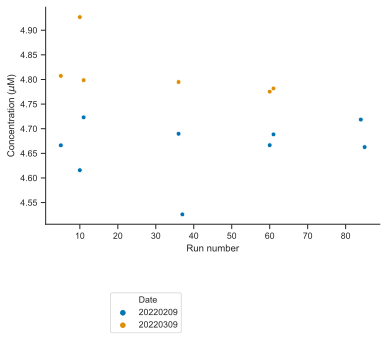

In [307]:
#Plot lines for a single ion
df_nitrate_prec = df_prec[(df_prec.Ion=='Nitrate')]
#fig = plt.figure(figsize = (7,7), facecolor='white')
#ax = fig.add_subplot(111)
p = sns.scatterplot(x='runno', y='Amount', data=df_nitrate_prec, hue='Date', palette='colorblind')
sns.despine()

plt.ylabel('Concentration ($\mu$M)')
plt.xlabel('Run number')
plt.legend(bbox_to_anchor=(0.3, -0.5), loc='lower center', borderaxespad=0)
#Save figure
plt.savefig(f'{homedir}/figures/ic_precision_NO3.pdf', bbox_inches='tight')

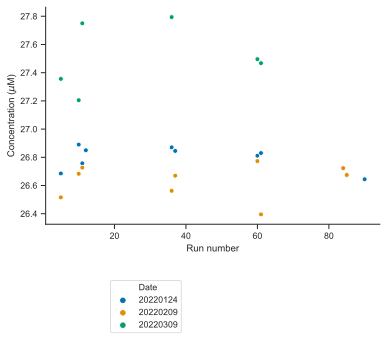

In [308]:
#Plot lines for a single ion
df_sulfate_prec = df_prec[(df_prec.Ion=='Sulfate')]
#fig = plt.figure(figsize = (7,7), facecolor='white')
#ax = fig.add_subplot(111)
p = sns.scatterplot(x='runno', y='Amount', data=df_sulfate_prec, hue='Date', palette='colorblind')
sns.despine()

plt.ylabel('Concentration ($\mu$M)')
plt.xlabel('Run number')
plt.legend(bbox_to_anchor=(0.3, -0.5), loc='lower center', borderaxespad=0)
#Save figure
plt.savefig(f'{homedir}/figures/ic_precision_SO4.pdf', bbox_inches='tight')